In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [2]:
env_name = 'MountainCar-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (256,)

batch_size = 64  # @param
learning_rate = 0.005 # @param
log_interval = 200  # @param
gamma = 1.0

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [3]:
env = suite_gym.load(env_name)

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [4]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [5]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    gamma=gamma,
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [6]:
eval_policy = tf_agent.policy
#collect_policy = tf_agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

# Make a epsilon greedy policy to use as collect policy
from tf_agents.policies import q_policy
from tf_agents.policies import epsilon_greedy_policy

MIN_EPSILON = 0.1
MAX_EPSILON = 1.0
DECAY_RATE = 0.0001

def make_epsilon_greedy_policy(train_step_counter):
    def e_greedy_decay():
        steps = train_step_counter.numpy()
        epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-DECAY_RATE * steps)
        return epsilon
    return e_greedy_decay

policy = q_policy.QPolicy(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    emit_log_probability=False)

In [7]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [8]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [9]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)


for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)
    
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [11]:
observations = tf.constant([
    [-0.45279628, 0.],
    [0.4794603, 0.01519559],
    [0.49532581, 0.01586551],
    [0.51197954, 0.01665372]
])

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

egreedy_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
          policy, epsilon=make_epsilon_greedy_policy(tf_agent.train_step_counter))

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

q0 = []
q1 = []
q2 = []
q3 = []

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, egreedy_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        q_values = tf_agent._q_network(observations)[0].numpy()
        q0.append(q_values[0,2])
        q1.append(q_values[1,2])
        q2.append(q_values[2,2])
        q3.append(q_values[3,2])        

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

W0717 22:44:06.591871 4795610560 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tf_agents/policies/epsilon_greedy_policy.py:96: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


step = 200: loss = 487.0287780761719
step = 400: loss = 25.106613159179688
step = 600: loss = 11.185754776000977
step = 800: loss = 80.68614196777344
step = 1000: loss = 8.690300941467285
step = 1000: Average Return = 39.400001525878906
step = 1200: loss = 286.81671142578125
step = 1400: loss = 423.45440673828125
step = 1600: loss = 668.1329345703125
step = 1800: loss = 500.43560791015625
step = 2000: loss = 296.2203063964844
step = 2000: Average Return = 134.5
step = 2200: loss = 570.9470825195312
step = 2400: loss = 528.3712768554688
step = 2600: loss = 88.0130844116211
step = 2800: loss = 751.0359497070312
step = 3000: loss = 789.656494140625
step = 3000: Average Return = 283.8999938964844
step = 3200: loss = 9606.1201171875
step = 3400: loss = 4400.6044921875
step = 3600: loss = 498.10943603515625
step = 3800: loss = 9328.0068359375
step = 4000: loss = 15283.4638671875
step = 4000: Average Return = 300.6000061035156
step = 4200: loss = 889.177734375
step = 4400: loss = 15377.577148

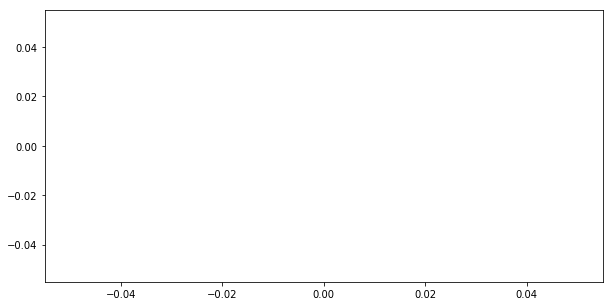

In [12]:
fig = plt.figure(figsize=(10,5))
plt.plot(q0)
plt.plot(q1)
plt.plot(q2)
plt.plot(q3)

(17.96000099182129, 550)

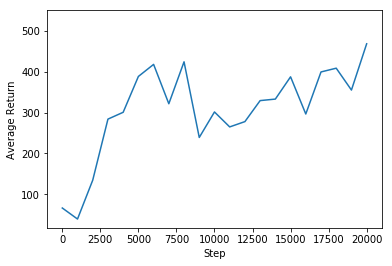

In [13]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [14]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = tf_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()